# Part 2: Model Construction

In [370]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB,ComplementNB
from sklearn.feature_selection import SelectKBest


from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report

df = pd.read_csv('Data\cleaned_data.csv')

#get rid of the extra index 
df = df.drop(columns = 'Unnamed: 0')

df.head() #looking good

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,total_charge
0,KS,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,75.56
1,OH,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,59.24
2,NJ,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,62.29
3,OH,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,66.80
4,OK,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,52.09


Before we start the process of constructing our model, it would help to know when we will know we are finished! Otherwise we would be beginning a race without knowing where the finish line is, which is no way to work. 
For SyriaTel, we will be prioritizing recall when evaluating the performance of models. This is because it is more important to capture all customers at risk of churn than it is to avoid classifying those not going to churn incorrectly. Put simply, SyriaTel will not mind being 'better safe than sorry' when classifying at-risk customers. 

In [371]:
# first we need to ensure that we are able to model our predictors effectively. let's check for multicollinearity through
# a correlation matrix.

<AxesSubplot:>

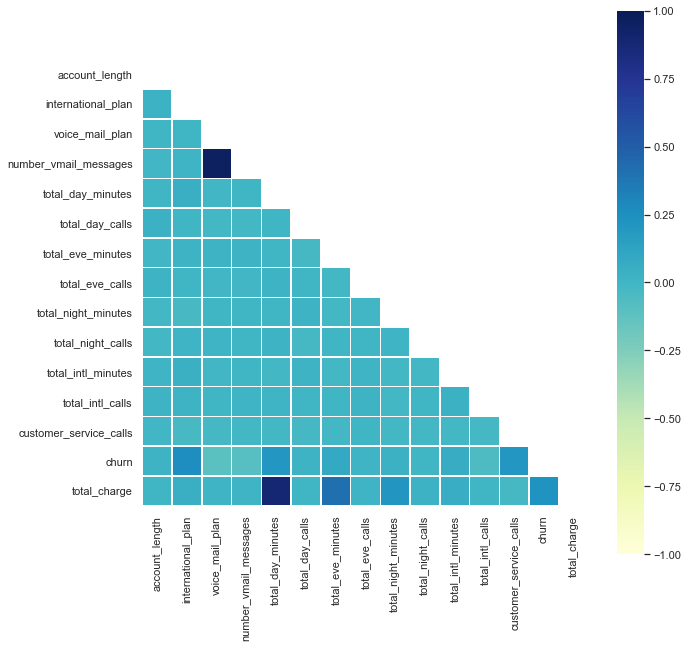

In [372]:
sns.set(style = 'white')

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype = np.bool))

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))


sns.heatmap(corr, mask = mask, cmap = "YlGnBu", center = 0, vmax = 1, vmin = -1, square = True, linewidths = 0.5)

In [373]:
# let's drop number_vmail_messages. This predictor is not normally distributed, nor does it give much information aside from
# how much a customer utilizes that service. 
df = df.drop('number_vmail_messages', axis = 1)

In [374]:
# we should also address the multicollinearity between total_day_minutes and total_charge. We can accomplish this through
#feature engineering. 

df['price_per_min'] = df['total_charge'] / (df.total_day_minutes + df.total_eve_minutes + df.total_night_minutes + df.total_intl_minutes)
df = df.drop(columns = ['total_charge', 'total_day_minutes', 'total_eve_minutes', 'total_night_minutes'])

<AxesSubplot:>

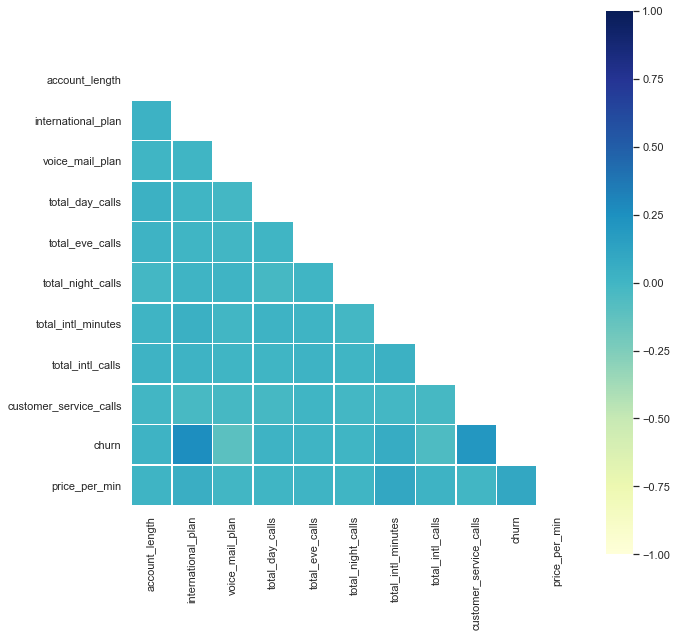

In [375]:
sns.set(style = 'white')

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype = np.bool))

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))


sns.heatmap(corr, mask = mask, cmap = "YlGnBu", vmax = 1, vmin = -1, center = 0, square = True, linewidths = 0.5)

In [376]:
# now that we have fully prepared our data for modelling, we need to construct columns for the categorical value 'states'

df_clean = pd.get_dummies(df)
df

,state,account_length,international_plan,voice_mail_plan,total_day_calls,total_eve_calls,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,price_per_min
0,KS,128,0,1,110,99,91,10.0,3,1,0,0.105354
1,OH,107,0,1,123,103,103,13.7,3,1,0,0.094754
2,NJ,137,0,0,114,110,104,12.2,5,0,0,0.115480
3,OH,84,1,0,71,88,89,6.6,7,2,0,0.118272
4,OK,75,1,0,113,122,121,10.1,3,3,0,0.101738
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,0,1,77,126,83,9.9,6,2,0,0.090964
3329,WV,68,0,0,57,55,123,9.6,4,3,0,0.108524
3330,RI,28,0,0,109,58,91,14.1,6,2,0,0.100266
3331,CT,184,1,0,105,84,137,5.0,10,2,0,0.111148


One very cool thing about having such a nicely non-multicollinear dataset is that we can safely go through with independence assumptions between predictors. This is helpful for Naive Bayes classification which we will be attempting further on.

# Logistic Regression Classifier

In [377]:
# these classes are heavily imbalanced, so in order to train our model effectively we will need to address this using SMOTE. 
# before we do so, we need to perform our train/test split for our logistic regression model. 


def get_xy(df, drops, target):
    X = df.drop(columns = drops)
    X = df.drop(columns = target)
    y = df[target]
    return X, y

X, y = get_xy(df_cleaned, drops = [], target = 'churn')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 10)
X
y.value_counts()
# we have a class imbalance of (Churn:Retained -> 1:6)

0    2850
1     483
Name: churn, dtype: int64

In [378]:
smote = SMOTE()

In [379]:
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

y_train_smote_counter = Counter(y_train_sm)

y_train_sm.sum() / len(y_train_sm)

# beecause the ratio of churn = 1 is 0.5, we know that the classes are now balanced!

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.5

In [380]:
logreg = LogisticRegression(fit_intercept = False, max_iter = 500, solver = 'liblinear')
logistic_model = logreg.fit(X_train_sm, y_train_sm)
logistic_model

LogisticRegression(fit_intercept=False, max_iter=500, solver='liblinear')

In [381]:
y_test_predictions = logreg.predict(X_test)
y_train_predictions = logreg.predict(X_train_sm)

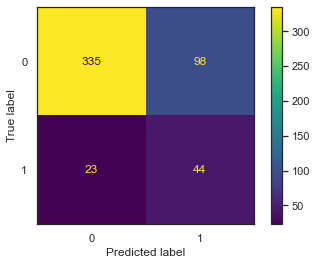

In [382]:
plot_confusion_matrix(logistic_model, X_test, y_test)

In [383]:
# remember that we are validating our model based on recall, because we want to capture every customer at risk of churning, and
# don't mind misclassifying those not at risk. False positives are allowed, but false negatives are not. 
print('Our Training Recall Score: ' , recall_score(y_train_sm, y_train_predictions))
print('Our Testing Recall Score: ' , recall_score(y_test, y_test_predictions))

Our Training Recall Score:  0.7819611088125775
Our Testing Recall Score:  0.6567164179104478


In [384]:
# this score is not good. not good at all. Let's try to adjust our parameters to acheive a greater recall metric. Instead of 
# manually adjusting everything, lets use a gridsearch. 

clf = LogisticRegression()

parameters = {
    "penalty": ['l1', 'l2'],
    "fit_intercept": [True, False],
    "max_iter": [100, 200, 300, 400, 500],
    "C": [0.25, 0.5, 1.0, 2.0, 5.0, 10.0],
    'solver': ['liblinear']}

In [385]:
gridsearch_cv = GridSearchCV(clf, param_grid = parameters, n_jobs = -1, verbose = 2, scoring = make_scorer(recall_score))

In [386]:
gridsearch_cv.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   36.7s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300, 400, 500],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring=make_scorer(recall_score), verbose=2)

In [387]:
gridsearch_results = pd.DataFrame(gridsearch_cv.cv_results_)

In [388]:
gridsearch_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.985817,0.783512,0.003591,0.000489,0.25,True,100,l1,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.766046,0.788820,0.807851,0.795455,0.790890,0.789812,0.013596,56
1,0.043484,0.004019,0.001596,0.001197,0.25,True,100,l2,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.761905,0.792961,0.797521,0.780992,0.795031,0.785682,0.013175,66
2,3.563872,0.317384,0.001197,0.000399,0.25,True,200,l1,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.766046,0.788820,0.807851,0.795455,0.790890,0.789812,0.013596,56
3,0.037898,0.002676,0.001397,0.000489,0.25,True,200,l2,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.761905,0.792961,0.797521,0.780992,0.795031,0.785682,0.013175,66
4,3.880625,0.597377,0.001197,0.000399,0.25,True,300,l1,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.766046,0.788820,0.807851,0.795455,0.790890,0.789812,0.013596,56


In [389]:
best_classifier = gridsearch_cv.best_estimator_

In [390]:
best_classifier.score(X_train_sm, y_train_sm)

0.7931319817956144

In [391]:
best_classifier.score(X_test, y_test)

0.778

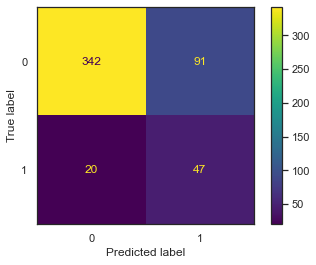

In [392]:
plot_confusion_matrix(best_classifier, X_test, y_test)

In [393]:
gridsearch_test_predictions = best_classifier.predict(X_test)
gridsearch_train_predictions = best_classifier.predict(X_train_sm)

In [394]:
print("Logistic Regression Gridsearch Training Recall Score: ", recall_score(y_train_sm, gridsearch_train_predictions))
print("Logistic Regression Gridsearch Testing Recall Score: ", recall_score(y_test, gridsearch_test_predictions))

Logistic Regression Gridsearch Training Recall Score:  0.8026479106330161
Logistic Regression Gridsearch Testing Recall Score:  0.7014925373134329


In [395]:
# while this is a great improvement from our earlier logistic model, we still need to do better than this. It is time to use
# a different model. 

# Random Forest Classifier

Because we prepared our data for a logistic regression model at the start of this notebook, lets begin fresh with an unaltered (aside from EDA cleaning) dataframe.

In [396]:
df_fresh = pd.read_csv('Data\cleaned_data.csv')
df_fresh = df_fresh.drop(columns = 'Unnamed: 0')
df_fresh.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,total_charge
0,KS,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,75.56
1,OH,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,59.24
2,NJ,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,62.29
3,OH,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,66.80
4,OK,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,52.09


In [397]:
# we need to get dummies for our states
df_freshly_dummied = pd.get_dummies(df_fresh)

In [398]:
training_df, validation_df = train_test_split(df_freshly_dummied, test_size = 0.15)
rfclf = RandomForestClassifier()
parameters = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 3, 5, 8, 10]
}

In [399]:
gridsearch_cv = GridSearchCV(rfclf, param_grid = parameters, n_jobs = -1, verbose = 2, scoring = make_scorer(recall_score))

In [400]:
X_train, y_train = get_xy(training_df, drops = [], target = 'churn')
X_validation, y_validation = get_xy(validation_df, drops = [], target = 'churn')

In [401]:
gridsearch_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  89 out of 100 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 8, 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring=make_scorer(recall_score), verbose=2)

In [402]:
gs_results_df = pd.DataFrame(gridsearch_cv.cv_results_)
gs_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021342,0.003919,0.004189,3.990889e-04,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,17
1,0.040092,0.004943,0.005585,1.196909e-03,1,20,"{'max_depth': 1, 'n_estimators': 20}",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,17
2,0.078191,0.004442,0.007380,4.886167e-04,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,17
3,0.158177,0.011365,0.013165,1.466174e-03,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,17
4,0.025332,0.005971,0.003989,1.168008e-07,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.228916,0.154762,0.035714,0.192771,0.409639,0.20436,0.121473,13


In [403]:
best_random_forest = gridsearch_cv.best_estimator_
best_random_forest.score(X_train, y_train)

0.9788210377691493

In [404]:
best_random_forest.score(X_validation, y_validation)

0.962

In [405]:
features = X_train.columns
feature_imports = best_random_forest.feature_importances_

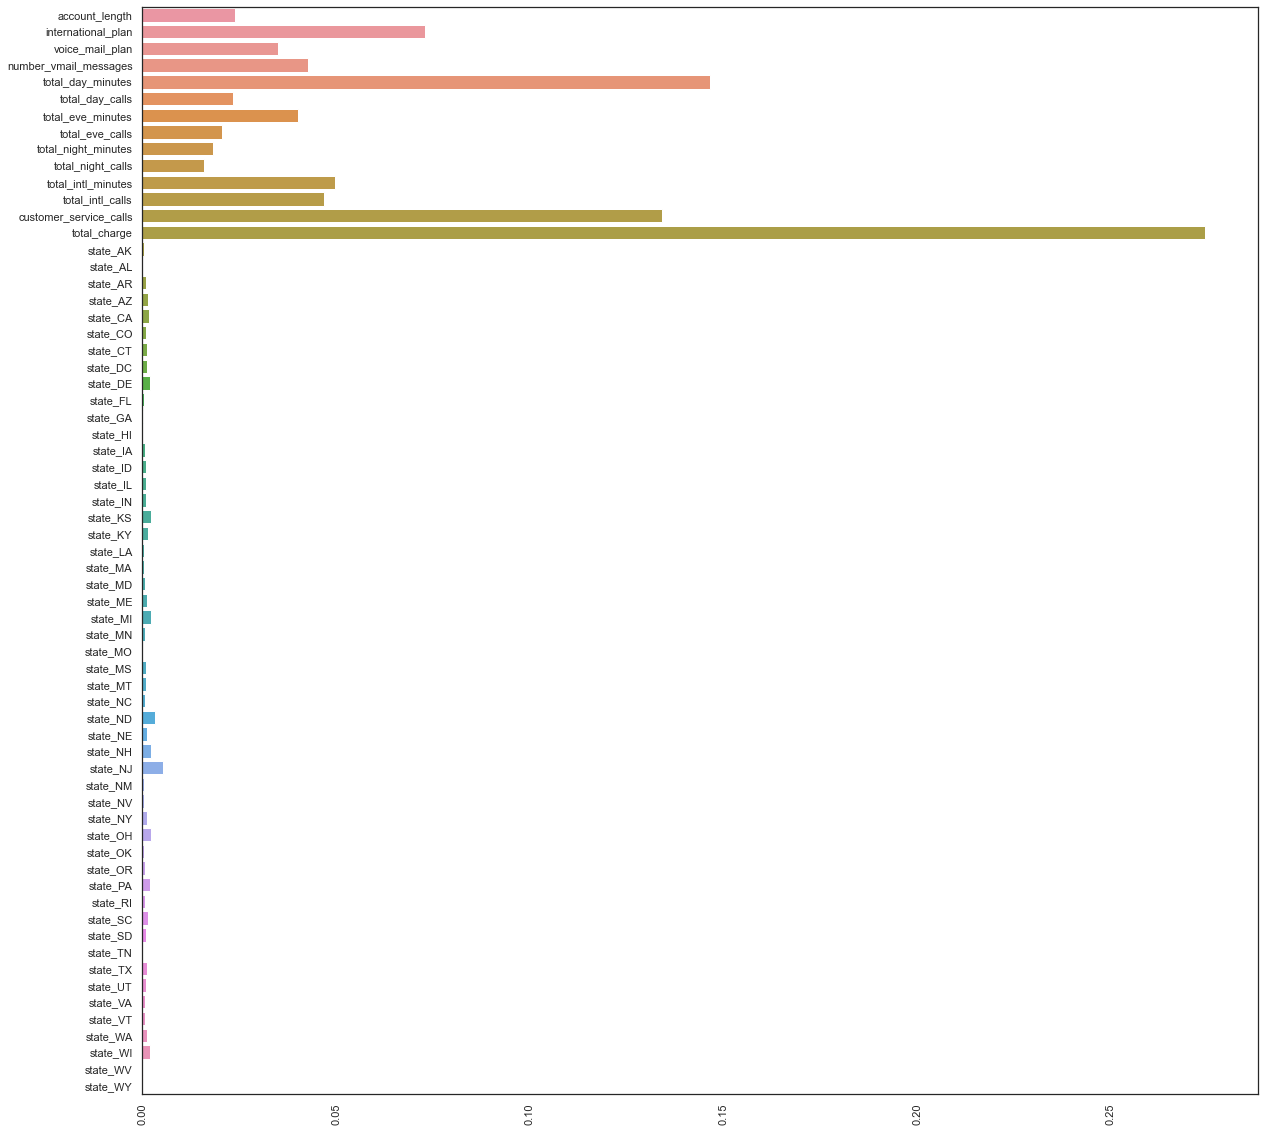

In [406]:
plt.figure(figsize = (20, 20))
sns.barplot(y = features, x = feature_imports)
plt.xticks(rotation = 90)
plt.show()
# from this bar graph, we can see that location information does not contribute to churn as heavily as other predictors. 
# lets seperate location information from the rest of the predictors. 

In [407]:
state_features = X_train.columns[-51:]
other_features = X_train.columns[0:10]
state_features

Index(['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI',
       'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY',
       'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN',
       'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH',
       'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD',
       'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA',
       'state_WI', 'state_WV', 'state_WY'],
      dtype='object')

[Text(0.5, 1.0, 'Location Predictors'), Text(0.5, 0, 'Importance')]

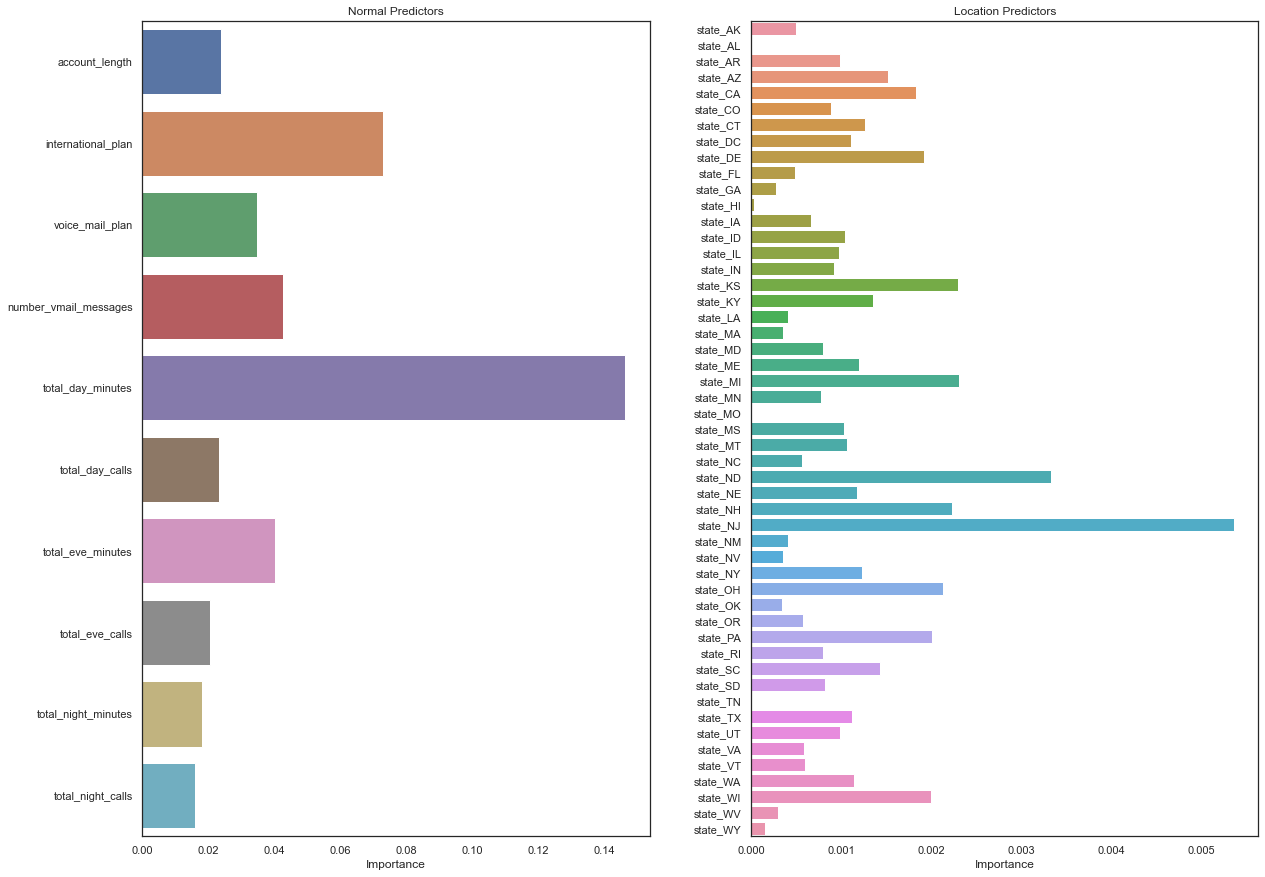

In [408]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 15))

sns.barplot(ax = axes[0], y = other_features, x = feature_imports[0:10]).set(title = 'Normal Predictors', xlabel = "Importance")
sns.barplot(ax = axes[1], y = state_features, x = feature_imports[-51:]).set(title = 'Location Predictors', xlabel = "Importance")

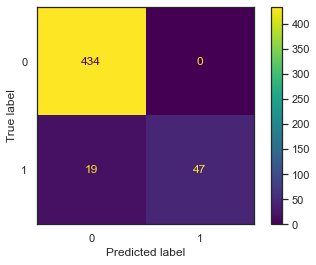

In [409]:
plot_confusion_matrix(best_random_forest, X_validation, y_validation)

In [427]:
#YES! we are improving our recall from logistic regression! It seems that the state predictors do not have great import, let's 
# drop these predictors to see if we can cut out the noise

# bring the df back from before getting dummy variables
df_refinement = df_fresh.copy()


In [428]:
if 'state' in df_refinement.columns:
    df_refinement = df_refinement.drop(columns = 'state')

In [429]:
df_refinement

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,total_charge
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,75.56
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,59.24
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,62.29
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,66.80
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0,60.10
3329,68,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0,63.53
3330,28,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0,67.74
3331,184,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0,57.53


In [430]:
training_df, validation_df = train_test_split(df_refinement, test_size = 0.15)
rfclf = RandomForestClassifier()
parameters = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 3, 5, 8, 10]
}

In [431]:
gridsearch_cv = GridSearchCV(rfclf, param_grid = parameters, n_jobs = -1, verbose = 2, scoring = make_scorer(recall_score))

In [432]:
X_train, y_train = get_xy(training_df, drops = [], target = 'churn')
X_validation, y_validation = get_xy(validation_df, drops = [], target = 'churn')

In [433]:
gridsearch_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  89 out of 100 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 8, 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring=make_scorer(recall_score), verbose=2)

In [434]:
gs_results_df = pd.DataFrame(gridsearch_cv.cv_results_)
gs_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017952,0.000631,0.003790,0.000399,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.130952,0.011765,0.000000,0.000000,0.00,0.028543,0.051407,17
1,0.033908,0.001669,0.004787,0.000399,1,20,"{'max_depth': 1, 'n_estimators': 20}",0.023810,0.000000,0.000000,0.000000,0.00,0.004762,0.009524,18
2,0.075797,0.001669,0.007979,0.001545,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,19
3,0.157978,0.006723,0.012566,0.001738,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,19
4,0.021343,0.001017,0.010572,0.013669,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.380952,0.411765,0.305882,0.440476,0.25,0.357815,0.070143,15


In [435]:
best_random_forest = gridsearch_cv.best_estimator_
best_random_forest.score(X_train, y_train)

0.9805859512883869

In [436]:
best_random_forest.score(X_validation, y_validation)

0.982

In [437]:
features = X_train.columns
feature_imports = best_random_forest.feature_importances_

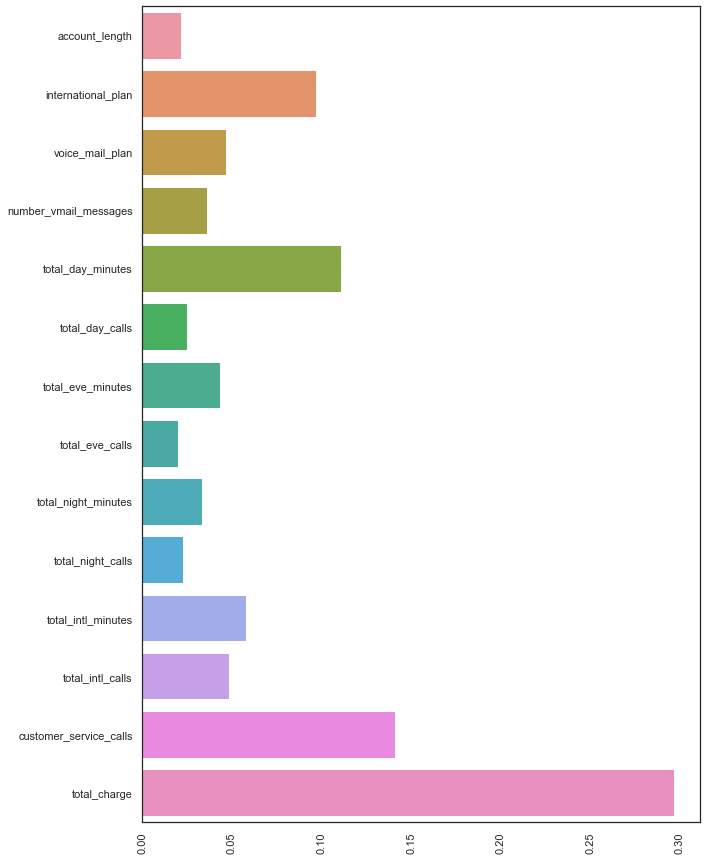

In [438]:
plt.figure(figsize = (10, 15))
sns.barplot(y = features, x = feature_imports)
plt.xticks(rotation = 90)
plt.show()


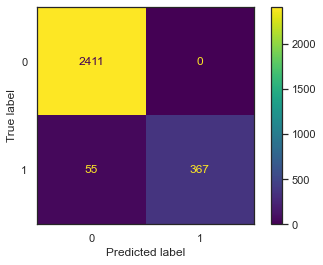

In [449]:
plot_confusion_matrix(best_random_forest, X_train, y_train)

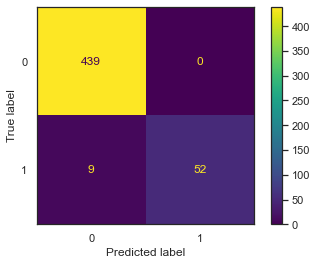

In [439]:
plot_confusion_matrix(best_random_forest, X_validation, y_validation)

In [440]:
# WOW! I am nervous to go any further than this! We only missed NINE people out of the 61 in our subsample. 
gridsearch_test_predictions = best_random_forest.predict(X_validation)
gridsearch_train_predictions = best_random_forest.predict(X_train)

In [445]:
print("Random Forest Gridsearch Training Recall Score: ", recall_score(y_train, gridsearch_train_predictions))
print("Random Forest Gridsearch Testing Recall Score: ", recall_score(y_validation, gridsearch_test_predictions))

Random Forest Gridsearch Training Recall Score:  0.8696682464454977
Random Forest Gridsearch Testing Recall Score:  0.8524590163934426


In [446]:
def cost_benefit_analysis(model, X_test, y_test):
    y_preds = model.predict(X_test)
    label_dict = {"TP":0, "FP": 0, "TN": 0, "FN": 0}
    for yt, yp in zip(y_test, y_preds):
        if yt==yp:
            if yt==1:
                label_dict["TP"] += 1
            else:
                label_dict["TN"] += 1
        else:
            if yp==1:
                label_dict["FP"] += 1
            else:
                label_dict["FN"] += 1
    cb_dict = {"TP": 50, "FP": -10, "TN": 0, "FN": -60}
    total = 0
    for key in label_dict.keys():
        total += cb_dict[key]*label_dict[key]
    return total / sum(label_dict.values())

In [448]:
print(cost_benefit_analysis(best_random_forest, X_validation, y_validation))

4.12


In [450]:
# what if we used the smote data from logistic regression above? Would that improve anything?

In [451]:
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

y_train_smote_counter = Counter(y_train_sm)

y_train_sm.sum() / len(y_train_sm)

# beecause the ratio of churn = 1 is 0.5, we know that the classes are now balanced!

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.5

In [453]:
gridsearch_cv.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  89 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 8, 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring=make_scorer(recall_score), verbose=2)

In [454]:
gs_results_df = pd.DataFrame(gridsearch_cv.cv_results_)
gs_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019547,0.000797,0.002195,0.000399,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.751037,0.739130,0.881743,0.709544,0.663900,0.749071,0.072830,18
1,0.042287,0.002720,0.005386,0.001353,1,20,"{'max_depth': 1, 'n_estimators': 20}",0.701245,0.840580,0.495851,0.724066,0.759336,0.704216,0.114414,20
2,0.093151,0.005592,0.006586,0.000492,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.609959,0.716356,0.724066,0.697095,0.844398,0.718375,0.075000,19
3,0.192884,0.016383,0.011769,0.000399,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.757261,0.853002,0.692946,0.850622,0.734440,0.777654,0.063969,17
4,0.030917,0.004886,0.002394,0.000489,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.842324,0.815735,0.846473,0.815353,0.908714,0.845720,0.034063,16


In [455]:
best_random_forest = gridsearch_cv.best_estimator_
best_random_forest.score(X_train_sm, y_train_sm)

0.975114060555786

In [456]:
best_random_forest.score(X_validation, y_validation)

0.968

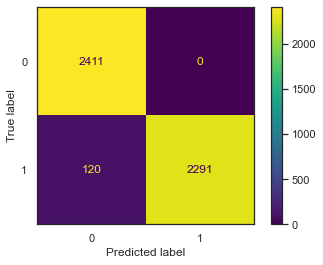

In [457]:
plot_confusion_matrix(best_random_forest, X_train_sm, y_train_sm)

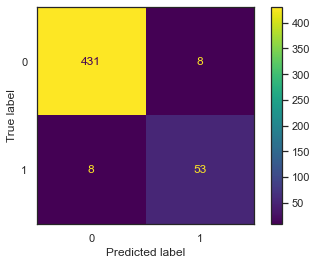

In [458]:
plot_confusion_matrix(best_random_forest, X_validation, y_validation)